### The classification of Food-101
Transfer Learning：ResNet-50

env: python3.6,tensorflow == 1.8.0

In [1]:
from __future__ import print_function
from __future__ import division

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Dense
from keras.layers import Input
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


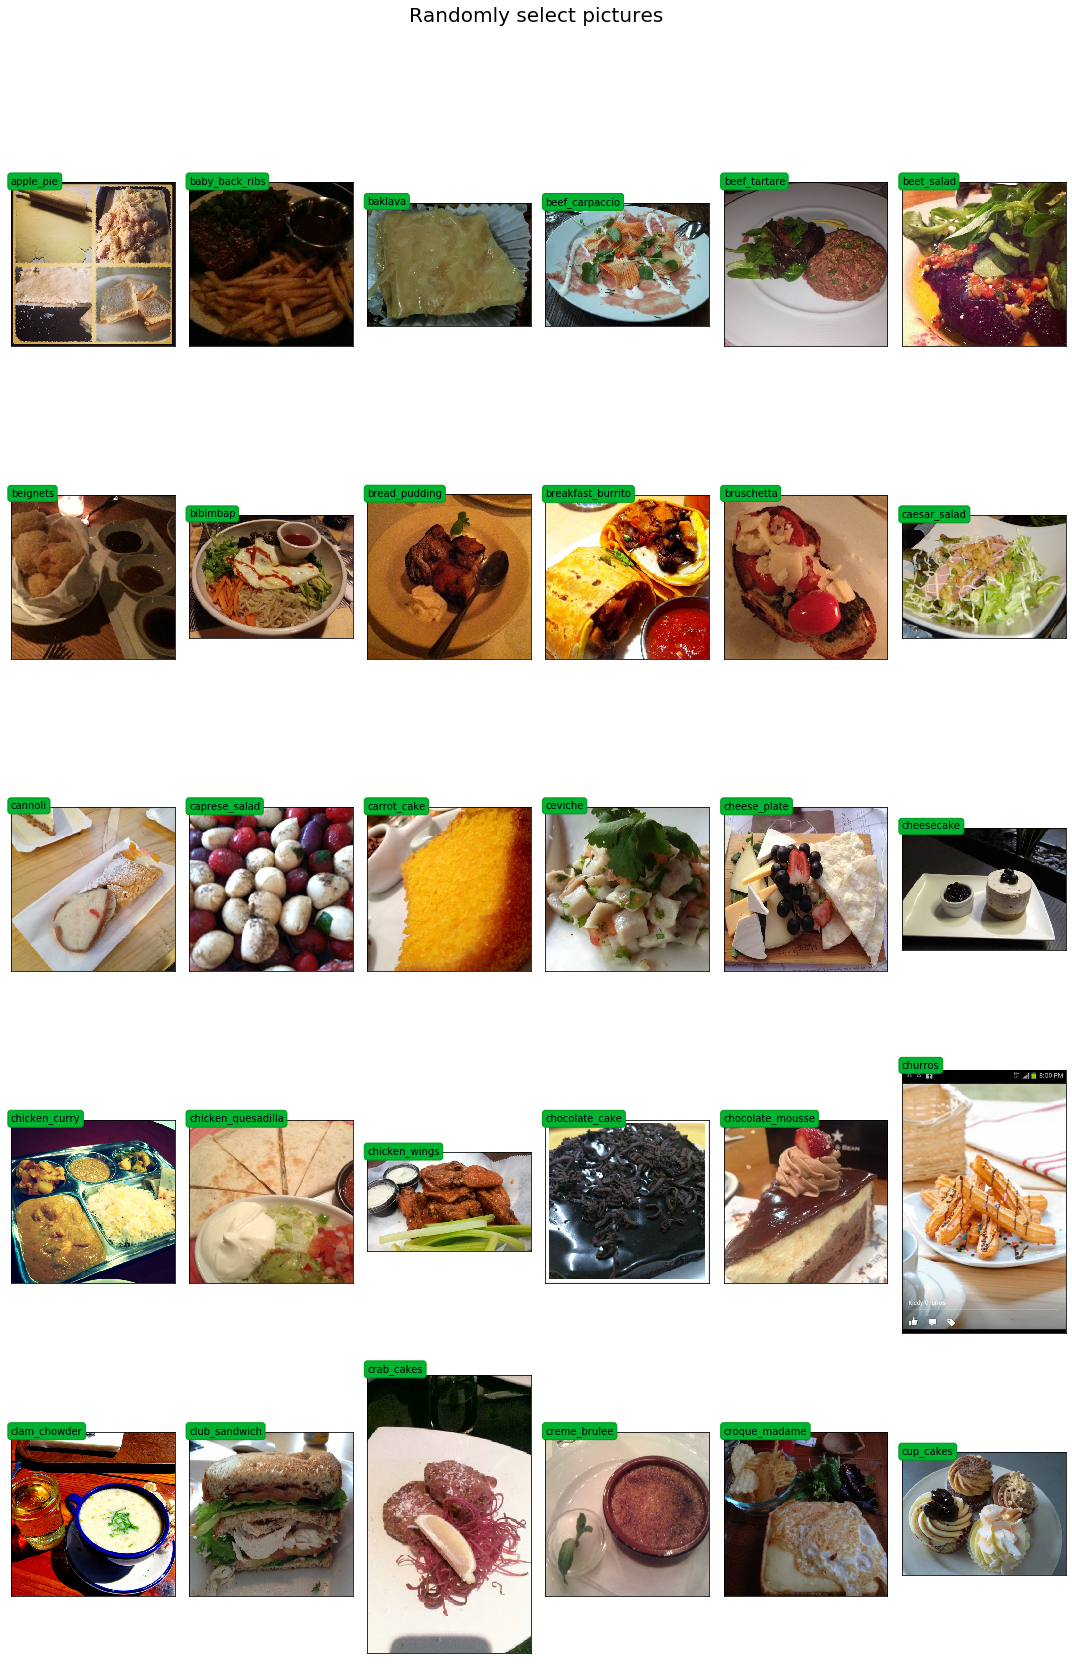

In [2]:
root_dir = '/home/gpu/Project/food-101/food-101/images/'

rows = 5
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(15, 25))
fig.suptitle('Randomly select pictures', fontsize=20) # create figure title
sorted_food_dirs = sorted(os.listdir(root_dir))  # sort from low to high

for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i * cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        
        # create sub-figure title
        ec = (0, 0.6, 0.1) # the color of the border line
        fc = (0, 0.7, 0.2) # the color of the background 
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0, ha='left', va='top', bbox=dict(boxstyle='round', ec=ec, fc=fc))
        
plt.setp(ax, xticks=[], yticks=[]) # set a properyty of ax
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # automatically adjust sub-figure parameters to fill the entire image area

In [3]:
# multiprocessing.Pool is used to accelerate image augmentation during training
import multiprocessing as mp

num_processes = 6
process_pool = mp.Pool(processes=num_processes)

Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gpu/anaconda3/envs/food101_py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gpu/anaconda3/envs/food101_py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gpu/anaconda3/envs/food101_py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gpu/anaconda3/envs/food101_py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gpu/anaconda3/envs/food101_py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File

In [4]:
# The function is used to split the dataset into a training set and a test set when the dataset hasn't split already.
from collections import defaultdict  # There is a default value for each key in the dictionary.
import shutil # High-level file operations

if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)# only copy the status information of src to dst
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('./food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('./food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('./food-101/images', './food-101/test', ignore=ignore_train)
    copytree('./food-101/images', './food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [5]:
def setup_generator(train_path, test_path, batch_size, dimentions):
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=dimentions,
        batch_size=batch_size)

    validation_generator = test_datagen.flow_from_directory(
        test_path, # this is the target directory
        target_size=dimentions,
        batch_size=batch_size)

    return train_generator, validation_generator

In [6]:
# load image
def load_image(img_path, dimentions, rescale=1. / 255):
    img = load_img(img_path, target_size=dimentions)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x *= rescale # rescale the same as when trained

    return x

In [7]:
# get classes label
def get_classes(file_path):
    with open(file_path) as f:
        classes = f.read().splitlines()

    return classes

In [8]:
# creat model
def create_model(num_classes, dropout, shape):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=Input(
            shape=shape))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model_final = Model(inputs=base_model.input, outputs=predictions)

    return model_final

In [9]:
# train model
def train_model(model_final, train_generator, validation_generator, callbacks, args):
    model_final.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    model_final.fit_generator(train_generator, validation_data=validation_generator,
                              epochs=args.epochs, callbacks=callbacks,
                              steps_per_epoch=train_generator.samples//args.batch_size,
                              validation_steps=validation_generator.samples//args.batch_size)

In [10]:
#load model
def load_model(weights_path, shape):
   model_final = create_model(101, 0, shape)
   model_final.load_weights(weights_path)

   return model_final

In [12]:
# training model

args = argparse.ArgumentParser(description='Food 101 Program')
args.batch_size = 32
args.epochs = 1
args.dropout = 0.2

shape = (224, 224, 3)


X_train, X_test = setup_generator('./food-101/train', './food-101/test', args.batch_size, shape[:2])

# debug purposes
print(X_train)

# call backs have to be array
callbacks = []

# add a callback
if not os.path.isdir('./saved_models_food101'):
    os.mkdir('./saved_models_food101')
callbacks.append(ModelCheckpoint(filepath='./saved_models_food101/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5',
                               verbose=1, save_best_only=True))

model_final = create_model(X_train.num_classes, args.dropout, shape)

train_model(model_final, X_train, X_test, callbacks, args)

In [13]:
# test model
args.model_path = './saved_models/weights.epoch-17-val_loss-1.06.hdf5'
args.image_path = './food-101/new_picture/1.jpg'

trained_model = load_model(args.model_path, shape)
image = load_image(args.image_path, shape[:2])
preds = trained_model.predict(image)
classes = get_classes('./food-101/meta/classes.txt')
print("The image is: {} - {:.2f}%".format(classes[np.argmax(preds)], max(preds[0, :]) * 100))

/home/gpu/anaconda3/envs/food101_py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


The image is: hot_dog - 31.12%


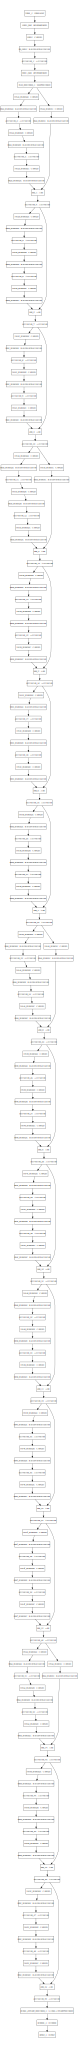

In [20]:
# visualization the trained_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(trained_model).create(prog='dot', format='svg'))

# save the trained_model to current path
from keras.utils.vis_utils import plot_model
plot_model(trained_model, to_file='trained_model.png', show_shapes=True, show_layer_names=True)

In [23]:
# visualization the trained_model parameters
from keras.utils import print_summary
print_summary(trained_model, line_length=None, positions=None, print_fn=None)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### convert Keras model to Tensorflow model
convert Keras's hdf5 to tensorflow's pb

In [25]:
from keras.models import load_model
import tensorflow as tf
import os 
import os.path as osp
from keras import backend as K

#file path
weight_file_path = osp.join(args.model_path)
output_graph_name =  'TF.pb' 

#convert function
def hdf5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = K.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)

#output path
output_dir = osp.join(os.getcwd(),"tensorflow_model")

#load Keras(hdf5) model
h5_model = load_model(weight_file_path)

#convert keras(hdf5) to tensorflow(pb) model
hdf5_to_pb(h5_model,output_dir = output_dir,model_name = output_graph_name)
print('model saved')

INFO:tensorflow:Froze 320 variables.
Converted 320 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=/home/gpu/Project/food-101/tensorflow_model
model saved


In [1]:
#using tensorboard to visualization

!tensorboard --logdir=./ tensorflow_model

2019-07-19 11:53:11.777068: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-07-19 11:53:11.857739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-07-19 11:53:11.858090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: GeForce GTX 1060 6GB major: 6 minor: 1 memoryClockRate(GHz): 1.7845
pciBusID: 0000:01:00.0
totalMemory: 5.93GiB freeMemory: 5.79GiB
2019-07-19 11:53:11.858106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2019-07-19 11:53:12.040553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-07-19 11:53:12.040583: I tensorflow/core/common_runtime/gpu/gpu_